In [1]:
import json 
import re
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np 
import pandas as pd
import pathlib 

from calibration_metric import ECEMetric
from calibration_metric.vis.calibration_plot import plot_df
from calibration_utils import get_accs_sql, read_benchclamp_file, get_probs_and_accs_benchclamp

/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:

paths = ["/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-small-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230203T092044.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-base-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230206T093954.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-large-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T064137.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-base_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T060905.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl"]
        # exclude codet5 since it's not used on smcalflow
        # "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/codet5-base_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T214405.jsonl"]

spider_gold_path = "/brtx/601-nvme1/estengel/resources/data/benchclamp/processed/Spider/test_all.jsonl"
spider_all_dfs = []
for path in paths: 
    bart_data = read_benchclamp_file(path)
    path = pathlib.Path(path)
    model_name = path.parent.name.split("_")[0]
    model_name = re.sub("-lm-adapt", "", model_name) 
    bart_min_probs, bart_mean_probs, bart_exact_accs = get_probs_and_accs_benchclamp(bart_data) # , spider_gold_path) 

    ece_metric = ECEMetric(n_bins=20, binning_strategy="adaptive")

    (min_values_em, 
    min_bins, 
    min_bin_number) = ece_metric.adaptive_bin(bart_min_probs, bart_exact_accs)

    min_df_to_plot_em = ece_metric.bins_to_df(min_values_em, min_bins, min_bin_number)
    min_df_to_plot_em["model"] = model_name

    source_ppl_data = json.load(open(f"spider_test_by_{model_name}_bin/conf_and_ppl_source.json"))
    target_ppl_data = json.load(open(f"spider_test_by_{model_name}_bin/conf_and_ppl_target.json"))

    print(model_name)
    print(len(source_ppl_data), len(min_df_to_plot_em))
    # sort by confidence, decreasing
    target_ppl_data = sorted(target_ppl_data, key=lambda x: x[0], reverse=True)
    source_ppl_data = sorted(source_ppl_data, key=lambda x: x[0], reverse=True)


    # add source data to df 
    min_df_to_plot_em['target_ppl'] = [x[1] for x in target_ppl_data]
    min_df_to_plot_em['source_ppl'] = [x[1] for x in source_ppl_data]
    spider_all_dfs.append(min_df_to_plot_em)



bart-large
7 7
t5-small
10 10
t5-base
8 8
t5-large
7 7
bart-base
9 9
bart-large
7 7


In [19]:


paths = ["/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-small-lm-adapt_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230223T160146.jsonl", # t5_small
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-base-lm-adapt_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230223T135433.jsonl", # t5_base
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-large-lm-adapt_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20221102T103315.jsonl",
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-base_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230222T155549.jsonl", # bart_base
        "/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_calflow_last_user_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20221101T105421.jsonl", # bart_large
        ]

calflow_gold_path = "/brtx/601-nvme1/estengel/resources/data/benchclamp/processed/CalFlowV2/test_all.jsonl"
calflow_all_dfs = []
for path in paths: 
    if path == "":
        continue

    bart_data = read_benchclamp_file(path)
    path = pathlib.Path(path)
    model_name = path.parent.name.split("_")[0]
    model_name = re.sub("-lm-adapt", "", model_name) 
    bart_min_probs, bart_mean_probs, bart_exact_accs = get_probs_and_accs_benchclamp(bart_data) # , spider_gold_path) 

    ece_metric = ECEMetric(n_bins=20, binning_strategy="adaptive")

    (min_values_em, 
    min_bins, 
    min_bin_number) = ece_metric.adaptive_bin(bart_min_probs, bart_exact_accs)


    ece_val = ece_metric(np.array(bart_min_probs), np.array(bart_exact_accs))
    print(f"Model: {model_name} ECE: {ece_val*100:.3f}")

    min_df_to_plot_em = ece_metric.bins_to_df(min_values_em, min_bins, min_bin_number)
    min_df_to_plot_em["model"] = model_name

    source_ppl_data = json.load(open(f"calflow_test_by_{model_name}_bin/conf_and_ppl_source.json"))
    target_ppl_data = json.load(open(f"calflow_test_by_{model_name}_bin/conf_and_ppl_target.json"))

    print(model_name)
    print(len(source_ppl_data), len(min_df_to_plot_em))
    # sort by confidence, decreasing
    source_ppl_data = sorted(source_ppl_data, key=lambda x: x[0], reverse=True)
    target_ppl_data = sorted(target_ppl_data, key=lambda x: x[0], reverse=True)

    # add source data to df 
    min_df_to_plot_em['source_ppl'] = [x[1] for x in source_ppl_data]
    min_df_to_plot_em['target_ppl'] = [x[1] for x in target_ppl_data]
    calflow_all_dfs.append(min_df_to_plot_em)

    # plot
    # plot_df(min_df_to_plot_em, title=model_name)
    # horizontal_plot(bart_min_probs, bart_exact_accs, path=None,
    #                 bclamp_data=bart_data, gold_path = spider_gold_path,
    #                 binning_strategy="adaptive", title=model_name)


Model: t5-small ECE: 14.262
t5-small
24 24
Model: t5-base ECE: 9.495
t5-base
20 20
Model: t5-large ECE: 8.286
t5-large
18 18
Model: bart-base ECE: 9.966
bart-base
17 17
Model: bart-large ECE: 6.231
bart-large
16 16


In [23]:
# concat all dfs 
spider_all_dfs = pd.concat(spider_all_dfs)

# ece is absolute difference between model and correct
spider_all_dfs['bin_ece'] = spider_all_dfs['prob_model'] - spider_all_dfs['prob_correct']
spider_all_dfs['bin_ece'] = spider_all_dfs['bin_ece'].abs()

# concat all dfs 
calflow_all_dfs = pd.concat(calflow_all_dfs)

# ece is absolute difference between model and correct
calflow_all_dfs['bin_ece'] = calflow_all_dfs['prob_model'] - calflow_all_dfs['prob_correct']
calflow_all_dfs['bin_ece'] = calflow_all_dfs['bin_ece'].abs()

In [51]:
"""stolen from https://gist.github.com/brentp/5355925"""


from sklearn import linear_model
from scipy import stats
import numpy as np


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, x, y, w, n_jobs=1):
        X = x.to_numpy().reshape(-1, 1)
        self = super(LinearRegression, self).fit(X, y, sample_weight=w)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])

        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        self.t = self.coef_ / se
        self.p = float(2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))

        # determine if self.coef_ should be positive or negative


        return self

-0.35798026958572454 1.3052552763753094
2.9494145303790234e-22
-0.3808218487918422 1.5096615997519605
1.4724490620208213e-29
-0.0162732490540389 0.30369715342235437
0.008214417086910604
0.026663060716457385 0.47744638412916196
9.185657751722474e-05


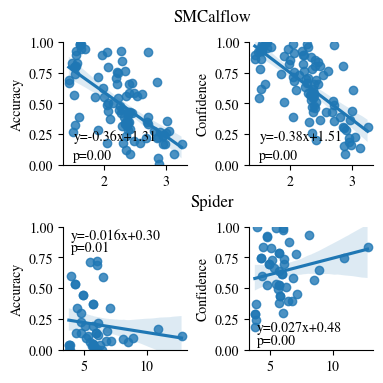

In [64]:
from matplotlib import pyplot as plt 
from scipy import stats 
from statsmodels.regression import linear_model
import statsmodels.api as sm 
plt.rcParams["font.family"] = "Nimbus Roman"

def get_reg_data_sklearn(x, y, w):
    model = LinearRegression()
    model.fit(x, y, w)

    # slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    print(model.coef_)
    slope = model.coef_[0]
    intercept = model.intercept_
    p_value = model.p
    return slope, intercept, p_value

def get_reg_data(x, y):
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()
    intercept, slope = results.params
    p_value = results.t_test([1, 0]).pvalue
    print(slope, intercept)
    print(p_value)
    return slope, intercept, p_value

# make plot for paper 
# don't plot ECE for now 
# fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw = dict(wspace=0.5, hspace=0.5))
fig, axs = plt.subplots(2, 2, figsize=(4, 4), sharex=False, sharey=False, gridspec_kw = dict(wspace=0.5, hspace=0.5))

# fill data 
# sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "bin_ece", ax = axs[0,0])
sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "prob_correct", ax = axs[0,0])
sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "prob_model", ax = axs[0,1])
# add slopes, intercepts, p-values as text 
# ece_slope, ece_intercept, ece_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['bin_ece'])
acc_slope, acc_intercept, acc_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['prob_correct']) 
conf_slope, conf_intercept, conf_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['prob_model']) 

# axs[0,0].text(1.5, 0.1, f"y={ece_slope:.2f}x+{ece_intercept:.2f}")
# axs[0,0].text(1.5, 0.05, f"p={ece_p_value:.2f}")

axs[0,0].text(1.5, 0.20, f"y={acc_slope:.2f}x+{acc_intercept:.2f}")
axs[0,0].text(1.5, 0.05, f"p={acc_p_value:.2f}")

axs[0,1].text(1.5, 0.20, f"y={conf_slope:.2f}x+{conf_intercept:.2f}")
axs[0,1].text(1.5, 0.05, f"p={conf_p_value:.2f}")

# plot spider 
# sns.regplot(data = spider_all_dfs, x = "source_ppl", y = "bin_ece", ax = axs[1,0])
sns.regplot(data = spider_all_dfs, x = "source_ppl", y = "prob_correct", ax = axs[1,0])
sns.regplot(data = spider_all_dfs, x = "source_ppl", y = "prob_model", ax = axs[1,1])
# ece_slope, ece_intercept, ece_p_value = get_reg_data(spider_all_dfs['source_ppl'], spider_all_dfs['bin_ece'])
acc_slope, acc_intercept, acc_p_value = get_reg_data(spider_all_dfs['source_ppl'], spider_all_dfs['prob_correct']) 
conf_slope, conf_intercept, conf_p_value = get_reg_data(spider_all_dfs['source_ppl'], spider_all_dfs['prob_model'])

# axs[1,0].text(1.5, 0.4, f"y={ece_slope:.2f}x+{ece_intercept:.2f}")
# axs[1,0].text(1.5, 0.25, f"p={ece_p_value:.2f}")

axs[1,0].text(4, 0.9, f"y={acc_slope:.3f}x+{acc_intercept:.2f}")
axs[1,0].text(4, 0.8, f"p={acc_p_value:.2f}")

axs[1,1].text(4, 0.15, f"y={conf_slope:.3f}x+{conf_intercept:.2f}")
axs[1,1].text(4, 0.05, f"p={conf_p_value:.2f}")

for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel("")
        
# first row is SMCalflow
axs[0,0].set_title("SMCalflow", x=1.2, y=1.1)
# second row is Spider
axs[1,0].set_title("Spider", x=1.2, y=1.1)
# first column is Calibration error
# axs[0,0].set_ylabel("Calibration error")
# axs[1,0].set_ylabel("Calibration error")
# second column is Accuracy
axs[0,0].set_ylabel("Accuracy") 
axs[1,0].set_ylabel("Accuracy")
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,1)
# third column is confidence
axs[0,1].set_ylabel("Confidence")
axs[1,1].set_ylabel("Confidence")
axs[0,1].set_ylim(0,1)
axs[1,1].set_ylim(0,1)
sns.despine()

# plt.savefig("/home/estengel/papers/calibration-parsing-2023/figures/calflow_vs_spider_ppl.pdf", bbox_inches='tight')

TypeError: get_reg_data() missing 1 required positional argument: 'w'

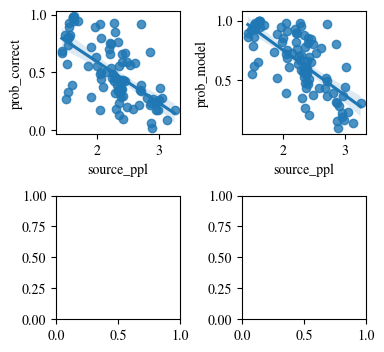

In [60]:
## What if we get rid of the two outlier bins 


fig, axs = plt.subplots(2, 2, figsize=(4, 4), sharex=False, sharey=False, gridspec_kw = dict(wspace=0.5, hspace=0.5))


# spider_df_no_outlier = spider_all_dfs[spider_all_dfs['source_ppl'] < 1000]
spider_df_no_outlier = spider_all_dfs[spider_all_dfs['source_ppl'] < 10]

# fill data 
# sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "bin_ece", ax = axs[0,0])
sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "prob_correct", ax = axs[0,0])
sns.regplot(data = calflow_all_dfs, x = "source_ppl", y = "prob_model", ax = axs[0,1])
# add slopes, intercepts, p-values as text 
# ece_slope, ece_intercept, ece_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['bin_ece'])
acc_slope, acc_intercept, acc_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['prob_correct'])
conf_slope, conf_intercept, conf_p_value = get_reg_data(calflow_all_dfs['source_ppl'], calflow_all_dfs['prob_model'])

# axs[0,0].text(1.05, 0.1, f"y={ece_slope:.2f}x+{ece_intercept:.2f}")
# axs[0,0].text(1.05, 0.05, f"p={ece_p_value:.2f}")

axs[0,0].text(1.5, 0.20, f"y={acc_slope:.2f}x+{acc_intercept:.2f}")
axs[0,0].text(1.5, 0.05, f"p={acc_p_value:.2f}")

axs[0,1].text(1.5, 0.20, f"y={conf_slope:.2f}x+{conf_intercept:.2f}")
axs[0,1].text(1.5, 0.05, f"p={conf_p_value:.2f}")

# plot spider 
# sns.regplot(data = spider_all_dfs, x = "source_ppl", y = "bin_ece", ax = axs[1,0])
sns.regplot(data = spider_df_no_outlier, x = "source_ppl", y = "prob_correct", ax = axs[1,0])
sns.regplot(data = spider_df_no_outlier, x = "source_ppl", y = "prob_model", ax = axs[1,1])
# ece_slope, ece_intercept, ece_p_value = get_reg_data(spider_all_dfs['source_ppl'], spider_all_dfs['bin_ece'])
acc_slope, acc_intercept, acc_p_value = get_reg_data(spider_df_no_outlier['source_ppl'], spider_df_no_outlier['prob_correct'])
conf_slope, conf_intercept, conf_p_value = get_reg_data(spider_df_no_outlier['source_ppl'], spider_df_no_outlier['prob_model'])

# axs[1,0].text(1.5, 0.4, f"y={ece_slope:.2f}x+{ece_intercept:.2f}")
# axs[1,0].text(1.5, 0.25, f"p={ece_p_value:.2f}")

axs[1,0].text(8.2, 0.9, f"y={acc_slope:.3f}x+{acc_intercept:.2f}")
axs[1,0].text(8.2, 0.8, f"p={acc_p_value:.2f}")

axs[1,1].text(15.2, 0.15, f"y={conf_slope:.3f}x+{conf_intercept:.2f}")
axs[1,1].text(15.2, 0.05, f"p={conf_p_value:.2f}")

for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel("")
        
# first row is SMCalflow
axs[0,0].set_title("SMCalflow", x=1.2, y=1.1)
# second row is Spider
axs[1,0].set_title("Spider", x=1.2, y=1.1)

# # first column is Calibration error
# axs[0,0].set_ylabel("Calibration error")
# axs[1,0].set_ylabel("Calibration error")
# second column is Accuracy
axs[0,0].set_ylabel("Accuracy") 
axs[1,0].set_ylabel("Accuracy")
axs[0,0].set_ylim(0,1)
axs[1,0].set_ylim(0,1)
# third column is confidence
axs[0,1].set_ylabel("Confidence")
axs[1,1].set_ylabel("Confidence")
axs[0,1].set_ylim(0,1)
axs[1,1].set_ylim(0,1)
axs[1,1].text(x = -50, y = -0.3, s = "Perplexity", fontsize=10)
sns.despine()

# plt.savefig("/home/estengel/papers/calibration-parsing-2023/figures/calflow_vs_spider_ppl_no_outlier.pdf", bbox_inches='tight')

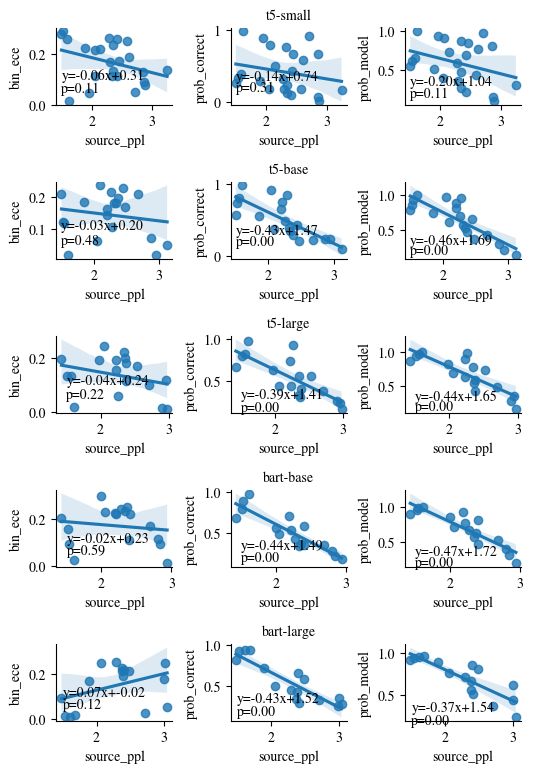

In [7]:
# smcalflow plot each one separately

fig, axs = plt.subplots(5, 3, figsize=(6, 9), sharex=False, sharey=False, gridspec_kw = dict(wspace=0.5, hspace=1.0))



# fill data 

for i, model in enumerate(['t5-small','t5-base','t5-large','bart-base','bart-large']):

    subset_df = calflow_all_dfs[calflow_all_dfs['model'] == model]
    sns.regplot(data = subset_df, x = "source_ppl", y = "bin_ece", ax = axs[i,0])
    sns.regplot(data = subset_df, x = "source_ppl", y = "prob_correct", ax = axs[i,1])
    sns.regplot(data = subset_df, x = "source_ppl", y = "prob_model", ax = axs[i,2])
    # add slopes, intercepts, p-values as text 
    ece_slope, ece_intercept, ece_p_value = get_reg_data(subset_df['source_ppl'], subset_df['bin_ece'])
    acc_slope, acc_intercept, acc_p_value = get_reg_data(subset_df['source_ppl'], subset_df['prob_correct'])
    conf_slope, conf_intercept, conf_p_value = get_reg_data(subset_df['source_ppl'], subset_df['prob_model'])

    axs[i,1].set_title(model, fontsize=10)
    axs[i,0].text(1.5, 0.1, f"y={ece_slope:.2f}x+{ece_intercept:.2f}")
    axs[i,0].text(1.5, 0.05, f"p={ece_p_value:.2f}")

    axs[i,1].text(1.5, 0.3, f"y={acc_slope:.2f}x+{acc_intercept:.2f}")
    axs[i,1].text(1.5, 0.15, f"p={acc_p_value:.2f}")

    axs[i,2].text(1.5, 0.3, f"y={conf_slope:.2f}x+{conf_intercept:.2f}")
    axs[i,2].text(1.5, 0.15, f"p={conf_p_value:.2f}")

sns.despine()
